In [1]:
%matplotlib inline

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.integrate as integrate
from matplotlib.animation import FuncAnimation
from matplotlib import rc
rc('animation', html='html5')

In [3]:
# PARAMETERS 
R = 8.314
INITIAL_TEMP = 293
ATM = 1e5
LIQUID_DENSITY = 1000  # Kg / m^3
AIR_DENSITY = 1.225  # Kg / m^3
G = -9.8
G_VEC = np.array([0, G])
GAMMA = 1.4
AIR_DRAG_COEFF = .75 

In [4]:
class Simulation:
    
    def __init__(self, *, 
                 bottle_volume=None, 
                 inside_pressure=None, 
                 nozzle_area=None, 
                 launch_angle=None, 
                 rocket_mass=None,
                 fill_factor=None,
                 rocket_face_area=None):
        
        self.Vb = bottle_volume
        self.P0 = inside_pressure
        self.NA = nozzle_area
        self.launch_angle = launch_angle
        self.M = rocket_mass
        self.V0 = bottle_volume * (1-fill_factor)
        self.V_liquid = bottle_volume * (fill_factor)
        self.FA = rocket_face_area
        self.K = inside_pressure * (bottle_volume * (1-fill_factor))**GAMMA
        self.initial_speed = np.sqrt(2 * (inside_pressure - ATM) / LIQUID_DENSITY)
        self.drag_coeff = AIR_DRAG_COEFF * .5 * AIR_DENSITY * self.FA
        
        if self.V_liquid > 1:
            raise ValueError("Fill factor too high")
        
        self._run = False
        
    def run(self):
        if self._run:
            raise Exception("Already run simulation")
        
        self._calc_launch()
        self._calc_flight()
        
        self._run = True
        
        
    def _calc_launch(self):
        def water_exit_acc(t, vel):
            A = - (GAMMA * self.K * self.NA) / LIQUID_DENSITY
            B = (.5 * LIQUID_DENSITY * vel**2 + ATM)
            return A * (B / self.K)**((GAMMA+1)/GAMMA)
        
        def find_limit(vel_func):
            expected_area = self.V_liquid / self.NA
            for limit in np.linspace(0, 1, 1000):
                if integrate.quad(vel_func, 0, limit)[0] > expected_area:
                    return limit
            return np.inf
    
        r_water_vel = integrate.solve_ivp(water_exit_acc, (0,1) , np.array([self.initial_speed]), dense_output=True)
        
        self.water_vel = np.vectorize(r_water_vel.sol)
        self.launch_time = find_limit(self.water_vel)
        
        total_mass = self.M + self.V_liquid * LIQUID_DENSITY
        
        def launch_acceleration(t, v):
            vm = np.linalg.norm(v)
            um = self.water_vel(t)
            mass = total_mass - integrate.quad(self.water_vel, 0, t)[0] * self.NA * LIQUID_DENSITY
            rocket_acc = (um**2 * self.NA * LIQUID_DENSITY - (vm ** 2 * self.drag_coeff)) / mass
            if (vm != 0):
                rocket_dir = v / vm
            else: 
                rocket_dir = [
                    np.cos(self.launch_angle / 180 * np.pi), 
                    np.sin(self.launch_angle / 180 * np.pi)
                ]
            return rocket_acc * rocket_dir + G_VEC
        
        self.instant_impulse = lambda t: self.water_vel(t)**2 * self.NA * LIQUID_DENSITY
        self.launch_impulse = integrate.quad(self.instant_impulse, 0, self.launch_time)[0]
        
        r_launch_vel = integrate.solve_ivp(
            launch_acceleration, 
            (0, self.launch_time), 
            np.array([0, 0]), 
            dense_output=True)
        
        self.launch_vel = r_launch_vel.sol
        self.launch_vel_vec = np.vectorize(lambda t, axis: r_launch_vel.sol(t)[axis])
        self.launch_vel_mod = np.vectorize(lambda t: np.linalg.norm(r_launch_vel.sol(t)))
        
        t = np.linspace(0, self.launch_time, 25)
        
        dx = self.launch_vel_vec(t, 0)
        dy = self.launch_vel_vec(t, 1)
        
        x = integrate.cumtrapz(dx, t, initial=0)[-1]
        y = integrate.cumtrapz(dy, t, initial=0)[-1]
        
        self.post_launch_pos = np.array([x, y])
        if self.post_launch_pos[1] <= 0:
            print("[Warning]: Values lead to a rocket that never leaves the floor")
        
    def _calc_flight(self):
        def drag_acceleration(t, vel):
            vm = np.linalg.norm(vel)
            return -(vm * self.drag_coeff / self.M) * vel + G_VEC
        
        initial_velocity = self.launch_vel(self.launch_time)

        r_vel_traject = integrate.solve_ivp(drag_acceleration, (0,100) , initial_velocity, dense_output=True)
        self.flight_vel_vec = np.vectorize(lambda t, axis: r_vel_traject.sol(t)[axis])
        self.flight_vel_mod = np.vectorize(lambda t: np.linalg.norm(r_vel_traject.sol(t)))

        t = np.linspace(0, 10, 1000)

        dy = self.flight_vel_vec(t, 1)
        y = integrate.cumtrapz(dy, t, initial=0) + self.post_launch_pos[1]
        
        self.flight_time = t[np.argmax(y < 0)]
        
        
    def calc_water_speed(self, plot=False):
        if not self._run:
            raise Exception("no values calculated yet")
            
        t = np.linspace(0, self.launch_time, 50)
        water_speed = self.water_vel(t)
        
        if plot:
            plt.figure(figsize=(10, 10))
            plt.plot(t, water_speed)
            plt.xlabel("Time since launch (s)")
            plt.ylabel("Water Speed at nozzle (m/s)")
            plt.title(f"Water exit velocity over time (pressure={self.P0/ATM} atm, water vol={self.V_liquid * 1000} litres)", fontsize=14)
            plt.grid(linestyle="--")
        else:
            return t, water_speed
        
    def calc_water_volume(self, plot=False):
        if not self._run:
            raise Exception("no values calculated yet")
            
        t = np.linspace(0, self.launch_time, 1000)
        volume = (self.V_liquid - np.cumsum(np.hstack([[0], self.water_vel(t[:999]) * self.NA * self.launch_time/1000])))*1000
        
        if plot:
            plt.figure(figsize=(10, 10))
            plt.plot(t, volume)
            plt.xlabel("Time since launch (s)")
            plt.ylabel("Water Volume (litres)")
            plt.title(f"Water volume over time (pressure={self.P0/ATM} atm, water vol={self.V_liquid * 1000} litres)", fontsize=14)
            plt.grid(linestyle="--")
        else:
            return t, volume
        
    def calc_rocket_thrust(self, plot=False):
        if not self._run:
            raise Exception("no values calculated yet")

        t = np.linspace(0, self.launch_time, 50)
        water_thrust = self.instant_impulse(t)
        
        if plot:
            plt.figure(figsize=(10, 10))
            plt.plot(t, water_thrust)
            plt.xlabel("Time since launch (s)")
            plt.ylabel("Thrust (n)")
            plt.title(f"Thrust over time (pressure={self.P0/ATM} atm, water vol={self.V_liquid * 1000} litres)", fontsize=14)
            plt.grid(linestyle="--")
        else:
            return t, water_thrust
            
    def calc_rocket_drag(self, plot=False):
        if not self._run:
            raise Exception("no values calculated yet")

        t1 = np.linspace(0, self.launch_time, 50)
        t2 = np.linspace(0, self.flight_time, 50)
        drag1 = self.launch_vel_mod(t1)**2*self.drag_coeff
        drag2 = self.flight_vel_mod(t2)**2*self.drag_coeff
        
        t = np.hstack([t1, t2 + self.launch_time])
        drag = np.hstack([drag1, drag2])
        
        if plot: 
            plt.figure(figsize=(10, 10))
            plt.plot(t, drag)
            plt.axvline(x=self.launch_time, color="red", linestyle="--")
            plt.xlabel("Time since launch (s)")
            plt.ylabel("Drag (n)")
            plt.title(f"Drag over time (pressure={self.P0/ATM} atm, water vol={self.V_liquid * 1000} litres)", fontsize=14)
            plt.grid(linestyle="--")
        else:
            return t, drag
        
        
    def calc_trajectory(self, plot=False):
        
        if not self._run:
            raise Exception("no values calculated yet")
            
        t_launch = np.linspace(0, self.launch_time, 50)
        t_flight = np.linspace(0, self.flight_time, 200)
        
        dx_launch = self.launch_vel_vec(t_launch, 0)
        dy_launch = self.launch_vel_vec(t_launch, 1)
        dx_flight = self.flight_vel_vec(t_flight, 0)
        dy_flight = self.flight_vel_vec(t_flight, 1)
        
        x_launch = integrate.cumtrapz(dx_launch, t_launch, initial=0)
        y_launch = integrate.cumtrapz(dy_launch, t_launch, initial=0)
        
        x_flight = integrate.cumtrapz(dx_flight, t_flight, initial=0) + self.post_launch_pos[0]
        y_flight = integrate.cumtrapz(dy_flight, t_flight, initial=0) + self.post_launch_pos[1]
        
        t = np.hstack([t_launch, t_flight + self.launch_time])
        x = np.hstack([x_launch, x_flight])
        y = np.hstack([y_launch, y_flight])
        
        if plot:
            plt.figure(figsize=(10, 10))
            plt.plot(x_launch, y_launch, color="red")
            plt.plot(x_flight, y_flight, color="C0")
            plt.xlabel("Distace (m)")
            plt.ylabel("Height (m)")
            plt.title(f"Trajectory (pressure={self.P0/ATM} atm, water vol={self.V_liquid * 1000} litres)", fontsize=14)
            plt.grid(linestyle="--")
            plt.axis("equal")
        else:
            return t, np.vstack([x, y]).T
        
    
    def show_trajectory(self):
        times, points = self.calc_trajectory()
        fig, ax = plt.subplots(figsize=(10, 10))
        
        max_x, max_y = points.max(axis=0) * 1.1
        
        ln, = plt.plot([], [], 'ro', animated=True)
        plt.xlabel("Distace (m)")
        plt.ylabel("Height (m)")
        plt.title(
            f"Trajectory in real time(pressure={self.P0/ATM} atm, water={self.V_liquid * 1000} litres, angle={self.launch_angle} deg)", 
            fontsize=14)
        plt.grid(linestyle="--")

        def init():
            ax.axes.set_aspect("equal")
            ax.set_xlim((0, max(max_x, 5)))
            ax.set_ylim((0, max(max_y,5)))
            return ln,

        def update(t):
            ix = np.argmax(times > t) - 1
            x, y = points[ix]
            ln.set_data(x, y)
            return ln,
        
        
        tot_time = self.launch_time + self.flight_time
        n_frames = tot_time * 25
        frames = np.linspace(0, 1, int(n_frames)) * tot_time 
        
        return FuncAnimation(fig, update, frames=frames,
                             init_func=init, interval=40, blit=True)

In [6]:
s = Simulation(
    bottle_volume=2.5/1000, 
    inside_pressure=4e5,
    nozzle_area=0.01**2 * np.pi, 
    launch_angle=65, 
    rocket_mass=.17,
    fill_factor=.4,
    rocket_face_area=0.05**2 * np.pi
)
s.run()

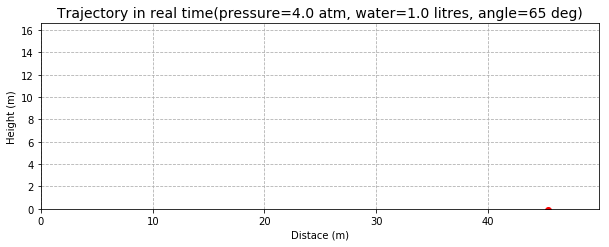

In [7]:
s.show_trajectory()

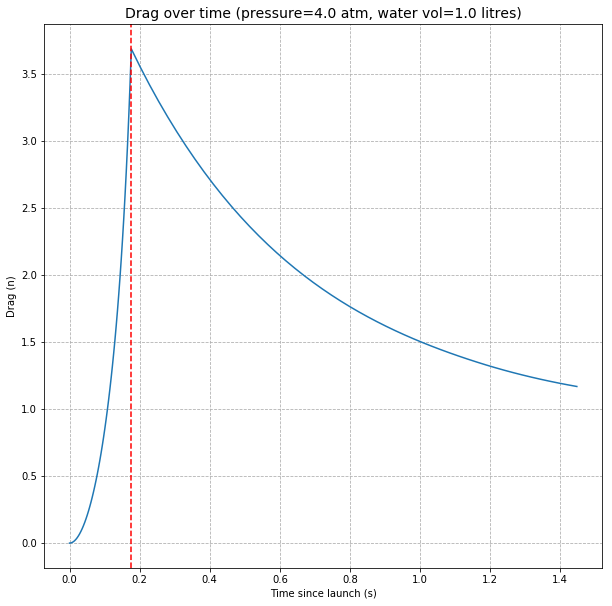

In [127]:
s.calc_rocket_drag(plot=True)

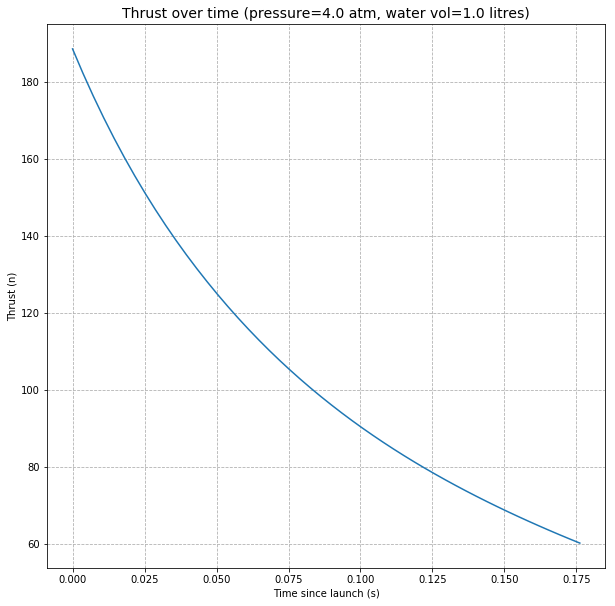

In [128]:
s.calc_rocket_thrust(plot=True)

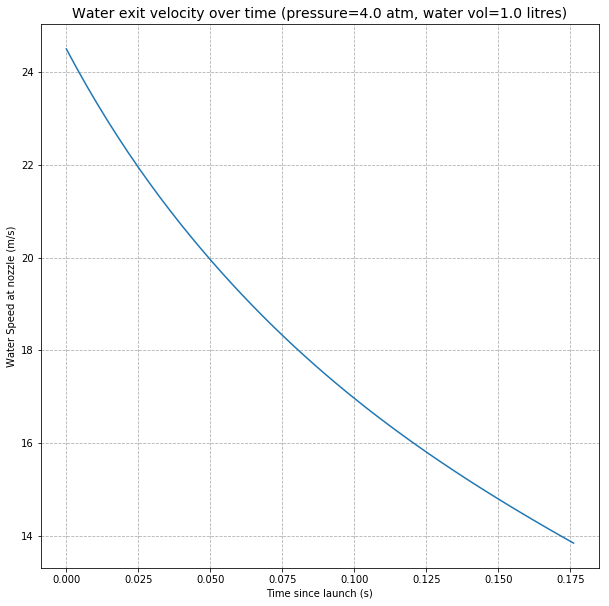

In [129]:
s.calc_water_speed(plot=True)

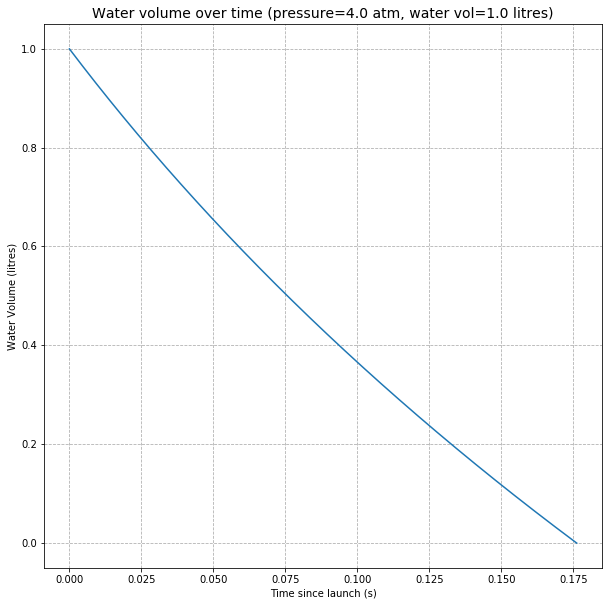

In [130]:
s.calc_water_volume(plot=True)

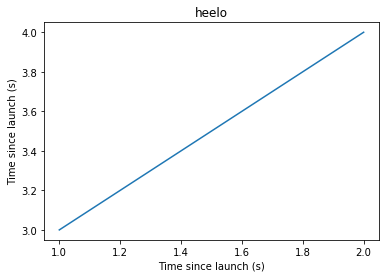

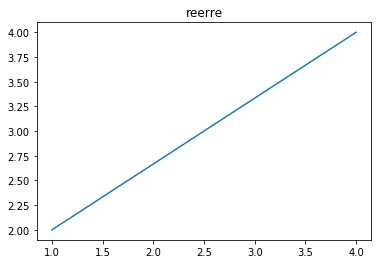

In [26]:
f1 = plt.figure()
a = f1.add_subplot(111)
a.set_title("heelo")
a.plot([1,2],[3,4])
a.set_xlabel("Time since launch (s)")
a.set_ylabel("Time since launch (s)")

f2 = plt.figure()
a = f2.add_subplot(111)
a.set_title("reerre")
a.plot([1,4],[2,4])

In [23]:
a.xaxis.set_label??